# Negative frequency-dependent selection in post-vaccine pneumococcal population 

Negative frequency-dependent selection (NFDS) is one mechanism that explains heterogeneity observed in bacterial populations. Under negative frequency-dependent selection, rare alleles are associated with a positive selection pressure. This affects the reproductive success of an individual, and alters the genetic variation in population. For example, when a novel antigen is introduced in a bacterial population, it tends to spread quickly among individuals due to the lack of immune responses. However, when the antigen is recognized more frequently among immune responses, it leads to a situation where the antigen is not beneficial anymore to an individual.

This notebook aims to repeat the experiments and reproduce results presented in [Corander et al.](https://doi.org/10.1038/s41559-017-0337-x) [1]. Experiments are repeated with pneumococcal population data collected in Massachutsetts [2]. Population dynamics are modelled with a simulator that predicts both NFDS and vaccination effects in reproductive success in the bacterial population, available [here](https://github.com/nickjcroucher/multilocusNFDS). The simulator parameters that control NFDS are estimated based on the observed population data with the BOLFI method [3] implemented in ELFI [4].

First, we introduce the observations used in the experiments. Then, we introduce two different models of negative frequency-dependent selection (NFDS) which are fitted to the observations based on comparison between observed and simulated population statistics: the homogenous-rate multilocus model of NFDS and heterogenous-rate multilocus model of NFDS. The libraries and resources used in this notebook are as follows:

In [1]:
%%capture

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import elfi
import operator
import GPy
import sys
import uuid
import os

%matplotlib inline
%precision 2

In [2]:
# Let's import the elfi_operations from code-folder.
sys.path.append('code')
import utils

In [3]:
# Let's determine the filepaths needed for this tutorial.
sample_file = './data/mass.input'
cogOrdering_file = './data/mass.cogOrdering'
simulator_path = './code/simulator/'

## Observed data

The Massachusetts dataset includes 616 pneumococcal isolates collected at three timepoints: first timepoint contains pre-vaccination samples, second timepoint contains midpoint samples, and third one contains late samples. The data is divided into 41 sequence clusters whose frequencies are visualized below. The isolates in each cluster are divided additionally into vaccinetype and non-vaccinetype isolates, and the three bars associated with each sequence cluster and type show the frequencies at different time points.

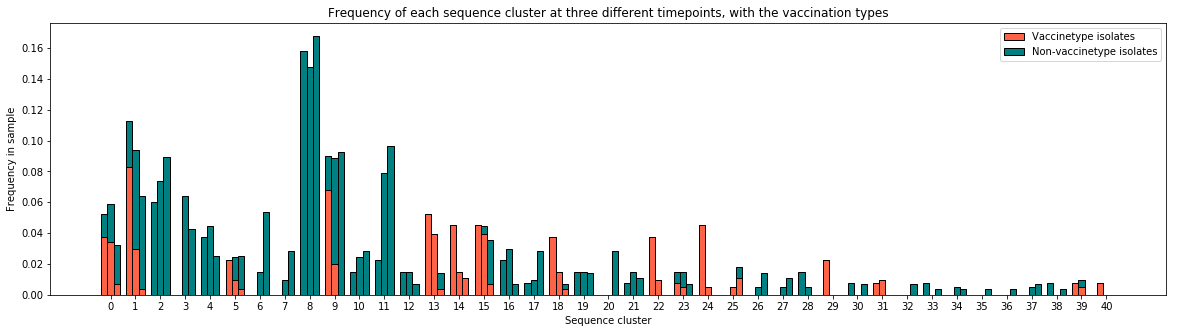

In [4]:
# Reads the observed samples from sample_file.
dt = np.dtype([('Time', np.int32), ('VT', np.int32), ('SC', np.int32)])
observed = [np.genfromtxt(sample_file, dtype = dt, names = True, usecols = (1, 3, 4))]

# Creates number of sequence clusters and timepoints. Will be used later as well.
SC = max(observed[0]['SC'])
timepoints_plot = utils.get_timepoints(observed, sum_node=0)

# Computes the sequence cluster frequencies at each time point for NVT and VT isolates.
freq_list = []
for timepoint in timepoints_plot:
    f = utils.frequency(observed, SC, timepoint)
    freq_list.append(f[0])

# Creates the frequency plot.
utils.frequency_plot(freq_list, SC, simulation=0)

In the experiments conducted in this notebook, we use the pre-vaccination samples to initialise simulations where a multilocus NFDS model is used to predict population dynamics, and then use the post-vaccination samples to evaluate the outcome.
This means that we divide the simulated population data into the above-discussed sequence clusters and compare the observed and simulated sequence cluster frequencies in the second and third timepoints.
We use this approach to estimate unknown NFDS model parameters based on the observed data, and later we also compare the results to determine which model better explains the observations.

## Homogenous-rate multilocus model of NFDS

NFDS models describe the reproductive success of an individual in a population under NFDS. The homogenous-rate multilocus model proposed in [1] models the number of offspring arising from individual $i$ at time $t$ as a Poisson-distributed random variable $X_{i,t}$:

$$X_{i, t} \sim Poi \left( \left( \frac{\kappa}{N_t} \right) \left( 1 - m\right) \left( 1 - v_i \right) \left( 1 + \sigma_f \right)^{\pi_{i, t}} \right).$$


The reproduction rate depends on environmental constrains as well as individual features. Factors that contribute in the environmental constrains and competition include the carrying capacity of the environment $\kappa$, current population size $N_t$, and migration rate $m$.
Factors related to the individual isolate $i$ include the vaccine-related fitness cost $v_i$ that is $v$ for vaccine-type isolates and $0$ otherwise, and $\pi_{i,t}$ that measures if the isolate contains genetic material that can be considered rare in the population at time $t$.
This introduces a fitness cost or bonus when $\sigma_f>0$ and the population is under NFDS.

The unknown model parameters that we want to estimate based on observed data are:

- maximal NFDS strength ($\sigma_f$, in elfi model `s`), 
- vaccine selection strength ($v$, in elfi model `v`), and 
- migration rate ($m$, in elfi model `i`). 


### ELFI

#### Creating the model and parameter nodes

We start by building a model `m` which has a structure of directed acylic graph. The model contains different nodes which are connected to each other by unidirectional arrow. These nodes can contain e.g. model parameters or operations.

Based on information provided in the article, we associate the parameters `v`, `s` and `i` with uniform prior distributions in the logaritmic domain, where parameter estimation is carried out. The distribution boundaries are defined in the `bounds` dictionary.

In [5]:
%%capture

# Creates the model.
m = elfi.ElfiModel(name='nfds')
# Boundaries for the priors, passed to Bolfi as well.
bounds = {'v': (-7, -0.69), 's': (-7, -1.5), 'i': (-7, -1.6)}
# Creates the priors.
elfi.Prior('uniform', bounds['v'][0], bounds['v'][1]-bounds['v'][0], model=m, name='v')
elfi.Prior('uniform', bounds['s'][0], bounds['s'][1]-bounds['s'][0], model=m, name='s')
elfi.Prior('uniform', bounds['i'][0], bounds['i'][1]-bounds['i'][0], model=m, name='i')

#### About the NFDS simulator and creating an external command on ELFI

The simulator used in the experiments can be found [here](https://github.com/nickjcroucher/multilocusNFDS). The NFDS simulator simulates the effect of negative frequency-dependent selection on the structure of the bacterial population over time, i.e. how this selection with the introduction of vaccination affects the observed distribution of sequence clusters over time.

In [6]:
!$simulator_path/compile.sh $simulator_path

An external command in ELFI is constructed in the following way, which includes the input parameters. Some of the parameter values are fixed based on the information from the article. The parameters which we want to estimate are defined with positional arguments `{}`.

In [7]:
# Command to call the simulator with homogenous multilocus model of NFDS.
sim_call_ho = '{simulator_path}/freqDepSelect -c CLS02514 -p f -v {0} -s {1} -i {2} -t 1 -n 100000 -g 72 -l 0.05 -u 0.95 -o {output_filename} -f {input_filename}'

There are two functions below, `prepare_inputs` and `process_result`, which are passed to ELFI. 

ELFI runs the NFDS simulator with parameter values selected based on parameter priors and previous evaluations. The input parameters are passed to the `prepare_inputs` function which saves the needed filepaths, creates unique filename for the simulator output, and does the exponential transformation to the parameters. Since the parameter estimation is carried out in log-compressed parameter domain, exponential transformation is needed when parameter values are passed on to the external simulator.

The second function, `process_result`, reads the simulations from the created file and picks the columns which are needed, and later deletes the file. Notice that the structure of the output is exactly the same as the structure of the observed data.

In [8]:
# Prepares inputs, kwinputs.
def prepare_inputs(*inputs, **kwinputs):
    input_list = list(inputs)    
    kwinputs['output_filename'] = 'MA.popsim_3_params_' + str(uuid.uuid4())
    kwinputs['input_filename'] = input_list[-1]
    kwinputs['simulator_path'] = input_list[-2]
    
    # Notice that there are two str-type inputs which are excluded.
    for i in range(len(input_list)-2):
        input_list[i] = np.exp(input_list[i])
        
    inputs = tuple(input_list)
    
    return inputs, kwinputs

# Function to process the result of the simulation.
def process_result(completed_process, *inputs, **kwinputs):
    #Reads the simulations from the file.
    output_filename = kwinputs['output_filename']
    output_filename += '.sample.out'
    dt = np.dtype([('Time', np.int32), ('VT', np.int32), ('SC', np.int32)])
    simulation = np.genfromtxt(output_filename, dtype = dt, names = True, usecols = (1, 3, 4))
        
    # Cleans up the output file after reading the data in.
    os.remove(output_filename)
    
    # This will be passed to ELFI as the result of the command.
    return simulation

#### Creating the simulator node

We use `elfi.tools.external_operation` to wrap the external command `sim_call_ho`, which was constructed earlier, as a Python callable which is then vectorized for ELFI. The simulator is then introduced in the model `m` as a simulator node `nfds_node` whose output will be the simulated data in the same format as the observed data. Here we also pass the input parameters to the `prepare_inputs` function.

In [9]:
# Creates the external command to call the simulator from ELFI.
nfds_sim = elfi.tools.external_operation(sim_call_ho, stdout=False, prepare_inputs=prepare_inputs, process_result=process_result)
# Vectorization of the external command.
nfds_sim_vector = elfi.tools.vectorize(nfds_sim)
# Creates the simulator node.
nfds_node = elfi.Simulator(nfds_sim_vector, m['v'], m['s'], m['i'], simulator_path, sample_file, name='nfds', observed=observed)

In [10]:
#For testing
#m.generate()

#### Adding summary, distance and operational nodes to the model

The experiments conducted in this notebook aim to find model parameters that minimise the distance between summary statistics calculated based on the observed and simulated data. The following section determines the summary, distance, and operational nodes which are added to the model `m`.

Summary node contains the function which creates informative summary statistic based on observed or simulated data. In this case, the observed or simulated isolate counts are summarised as sequence cluster frequencies which are computed as described in the observed data section earlier in this notebook.

Here, sequence cluster frequencies are calculated at the post-vaccination timepoints, and comparison between the observed and simulated data is based on Jensen-Shannon distance between the frequencies.

Finally, we create the discrepancy node `d_sum` which sums the Jensen-Shannon distances over the timepoints. This node will be passed to BOLFI which tries to minimize this discrepancy to obtain parameter estimates.

In [11]:
# Timepoints which are not 0, in this case only 36 and 72.
timepoints = utils.get_timepoints(observed)

# Summary nodes for different timepoints which are used to compute discrepancy.
s_36 = elfi.Summary(utils.frequency, nfds_node, SC, timepoints[0])
s_72 = elfi.Summary(utils.frequency, nfds_node, SC, timepoints[1])

# Distance nodes with operational nodes to create Jensen-Shannon divergence.
d_36 = elfi.Distance('jensenshannon', s_36)
o_36 = elfi.Operation(np.log, d_36) #np.square
d_72 = elfi.Distance('jensenshannon', s_72)
o_72 = elfi.Operation(np.log, d_72) #np.square

# This final node is passed to BOLFI.
d_sum = elfi.Operation(operator.add, o_36, o_72)

The structure of the whole model can be seen in the figure below.

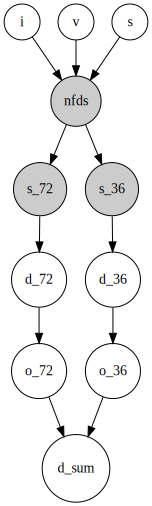

In [12]:
elfi.draw(m)

### BOLFI

Earlier, we computed the discrepancy between the observed and simulated data in which the different values of the parameters `v`, `s` and `i` are generated. Smaller values of the discrepancy indicate that the used model explains the observations better, and thus, we want to minimize the discrepancy. We can use Bayesian optimatization for likelihood-free inference (BOLFI) to minimize the discrepancy.

BOLFI creates a regression problem where the parameter values are the inputs and the expected discrepancy is the output of the regression function. The regression function is a Gaussian process with specific mean function and kernel, which are determined in `create_target_model` function. Also, an acquisition function `acq`, in this case maximum variance acquisition method, is used to guide the selection of the next parameter combination to be evaluated.

More information about BOLFI is provided in the article of [Gutmann and Corander](http://jmlr.org/papers/v17/15-017.html) [3].

In [13]:
# Creates the target GP model
target_model = utils.create_target_model(m, bounds)
# Creates acquisition function.
prior = elfi.methods.utils.ModelPrior(m)
acq = elfi.methods.bo.acquisition.MaxVar(model=target_model, prior=prior)

In [14]:
# Creates BOLFI object
ho_bolfi = elfi.BOLFI(d_sum,
                      batch_size=1,
                      initial_evidence=50,
                      update_interval=10,
                      bounds=bounds,
                      target_model=target_model,
                      acquisition_method=acq)

steps = 2000
%time ho_post = ho_bolfi.fit(n_evidence=steps)

Progress: |██████████████████████████████████████████████████| 100.0% Complete
CPU times: user 1h 48min 3s, sys: 7min 49s, total: 1h 55min 53s
Wall time: 4h 30min 58s


#### Contour plots
This part contains the contour and discrepancy plots which can be used to visualize the different values of discrepancy with different parameter combinations. In the contour plots, blue indicates smaller discrepancy value and yellow greater discrepancy value.

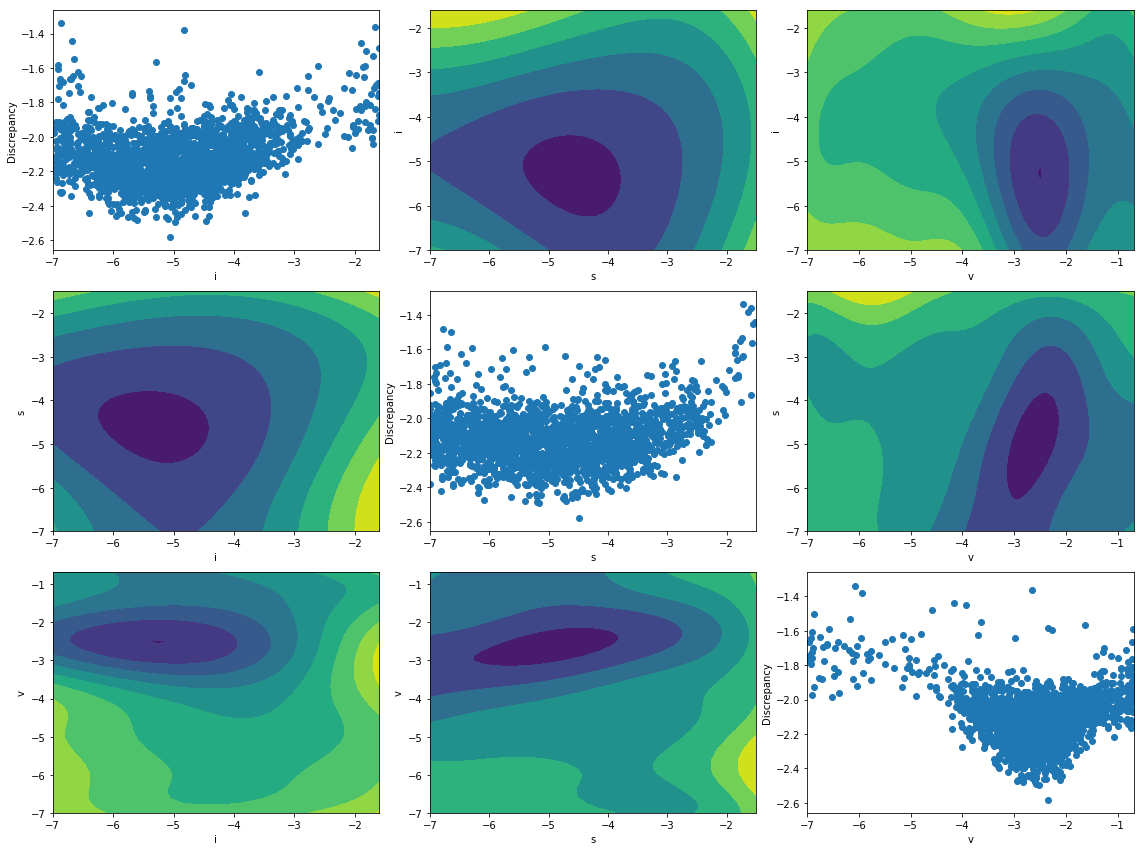

In [15]:
cont_plot = ho_bolfi.plot_gp()

#### Target model and length scales
The used and updated target model can be extracted in following way. The updated lengthscales for each parameter can be extracted in similar way from the target model.

In [16]:
ho_bolfi.target_model


Name : GP regression
Objective : -2003.6164692721693
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |   priors 
  rbf.variance             |     0.6967955267634014  |      +ve      |          
  rbf.lengthscale          |                   (3,)  |      +ve      |  Ga(2, 2)
  Gaussian_noise.variance  |  0.0067713350110088395  |      +ve      |          

The updated lengthscales of the target model are presented below.

In [17]:
ho_bolfi.target_model._gp.rbf.lengthscale

index,GP_regression.rbf.lengthscale,constraints,priors
[0],4.36590624,+ve,"Ga(2, 2)"
[1],2.48200095,+ve,"Ga(2, 2)"
[2],1.40094692,+ve,"Ga(2, 2)"


#### Finding the parameter values which minimize the discrepancy
Below, the function `find_min` has been used to extract the parameter values which minimize the discrepancy between the simulated values and observed samples. The values of the parameter and discrepancy can be seen below. We will compare the values obtained here to values of another model later. Notice that `parameter_names` attribute returns the parameters in alphapetical order which can be seen below.

In [18]:
xmin, fmin = utils.find_min(ho_bolfi.target_model,[bounds[name] for name in m.parameter_names])
parameter_names_3 = m.parameter_names  # Stores current parameter names.

print('\033[1m' + '\nValues of the parameters which minimize the (expected) discrepancy:' + '\033[0m')
utils.print_find_min(parameter_names_3, np.exp(xmin), fmin[0][0])


Values of the parameters which minimize the (expected) discrepancy:
parameters:	i	s	v
min values:	0.00548	0.00743	0.07280

fmin:	-2.309457189412072	
minimum_jsd:	0.009863498273455697


## Heterogenous-rate multilocus model of NFDS

This model is more complex compared to the previous one. It contains the same three rates with additional two ones which we want to estimate. The following rates are: 

- weaker NFDS strength ($\sigma_w$, in elfi model `j`) and
- proportion of loci under strong NFDS ($p_f$, in elfi model `y`).

And now the random variable $X_{i,t}$, number of offspring arising from individual $i$ at time $t$, is Poisson-distributed which includes the following terms: 

$$X_{i, t} \sim Poi \left( \left( \frac{\kappa}{N_t} \right) \left( 1 - m\right) \left( 1 - v_i \right) \left[ \left( 1 + \sigma_f \right)^{\pi_{i, t}} + \left( 1 + \sigma_w \right)^{\omega_{i, t}} \right] \right).$$

### ELFI

Instead of creating a new model, we will update the simulator in the existing model `m` and add the missing parameter nodes. Model structure remains otherwise the same.

Let's define new `prepare_inputs` function. In heterogenous-rate multilocus model of NFDS, the simulator needs additional file which includes the order of the clusters of orthologous genes (COGs). We will pass this file as one of the inputs to the function, just like in the previous model.

In [19]:
#Let's create a new prepare_inputs function
def prepare_inputs_he(*inputs, **kwinputs):
    input_list = list(inputs)
    kwinputs['output_filename'] = 'MA.popsim_5_params_' + str(uuid.uuid4())
    #This file contains the order of the COGs which are passed to simulator
    kwinputs['COG_ordering_file'] = input_list[-1]
    kwinputs['input_filename'] = input_list[-2]
    kwinputs['simulator_path'] = input_list[-3]

    for i in range(len(input_list)-4): #y is not transformed
        input_list[i] = np.exp(input_list[i])
        
    inputs = tuple(input_list)
    
    return inputs, kwinputs

#### Updating the nodes of the model

In the following section, we have defined a new set of parameters which follow uniform prior distributions. Here, prior information about parameter `j` ($\sigma_w < \sigma_f$) is added to the model via the operational node. As seen in the earlier section, the rate `y` is not transformed. Also notice that now we are using the `sim_call_he` external command to call the simulator.

In [20]:
#Let's update the bounds-dict with the boundaries of the two new parameters j and y
bounds['j'] = (-7, -1.89)
bounds['y']= (0.001, 1)

#We have prior knowledge about the parameter j, let's take that into account.
scale = elfi.Operation(operator.sub, m['s'], bounds['j'][0], name='scale')
elfi.Prior('uniform', bounds['j'][0], scale, model=m, name='j')
elfi.Prior('uniform', bounds['y'][0], bounds['y'][1]-bounds['y'][0], model=m, name='y')

#Command to call the simulator but this time for the heterogenous multilocus model of NFDS.
sim_call_he = '{simulator_path}/freqDepSelect -c CLS02514 -p f -v {0} -s {1} -i {2} -j {3} -y {4} -t 1 -n 100000 -g 72 -l 0.05 -u 0.95 -o {output_filename} -f {input_filename} -r {COG_ordering_file}'

#Creates the external command
he_nfds_sim = elfi.tools.external_operation(sim_call_he, stdout=False, prepare_inputs=prepare_inputs_he, process_result=process_result)
he_nfds_sim_vector = elfi.tools.vectorize(he_nfds_sim)
nfds_node.become(elfi.Simulator(he_nfds_sim_vector, m['v'], m['s'], m['i'], m['j'], m['y'], simulator_path, sample_file, cogOrdering_file, observed=observed))

Below we can see the updated model which contains old and new nodes.

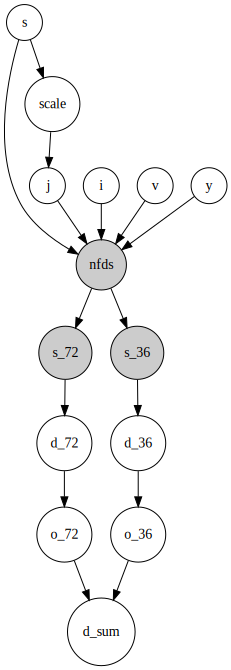

In [21]:
#Updated model
elfi.draw(m)

In [22]:
#Testing the simulator
#m.generate()

### BOLFI

Now we will define the target model and aqcuisition method again for the updated model. These with the discrepancy node will be passed to BOLFI in similar way as done before.

In [23]:
# Creates the target GP model
target_model2 = utils.create_target_model(m, bounds)
#Acquisition function
prior2 = elfi.methods.utils.ModelPrior(m)
acq2 = elfi.methods.bo.acquisition.MaxVar(model=target_model2, prior=prior2)

In [24]:
# Creates BOLFI object
he_bolfi = elfi.BOLFI(d_sum,
                      batch_size=1,
                      initial_evidence=50,
                      update_interval=10,
                      bounds=bounds,
                      target_model=target_model2,
                      acquisition_method=acq2)

steps = 2000
%time he_post = he_bolfi.fit(n_evidence=steps)

 /anaconda3/envs/elfi/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1720: RuntimeWarning:divide by zero encountered in true_divide
 /anaconda3/envs/elfi/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1762: RuntimeWarning:divide by zero encountered in true_divide


Progress: |██████████████████████████████████████████████████| 100.0% Complete
CPU times: user 2h 24min 44s, sys: 10min 24s, total: 2h 35min 9s
Wall time: 4h 45min 42s


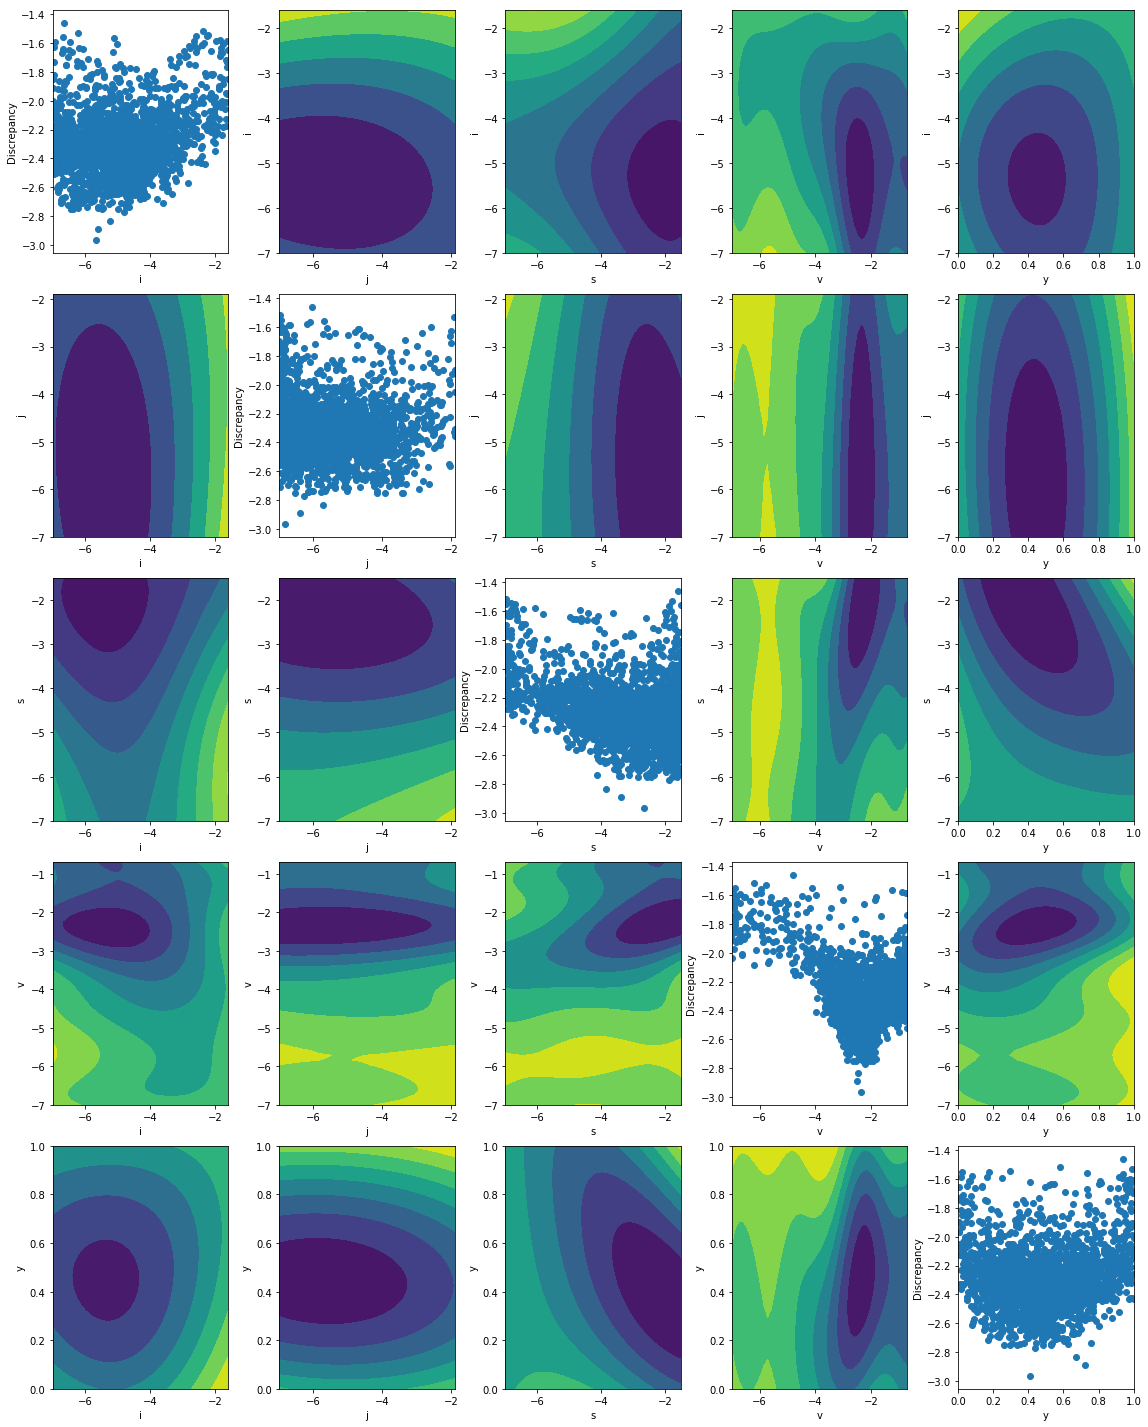

In [25]:
cont_plot2 = he_bolfi.plot_gp()

In [26]:
he_bolfi.target_model


Name : GP regression
Objective : -1642.1395632827114
Number of Parameters : 7
Number of Optimization Parameters : 7
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |   priors 
  rbf.variance             |    0.5651771496855644  |      +ve      |          
  rbf.lengthscale          |                  (5,)  |      +ve      |  Ga(2, 2)
  Gaussian_noise.variance  |  0.008448449563232591  |      +ve      |          

In [27]:
he_bolfi.target_model._gp.rbf.lengthscale

index,GP_regression.rbf.lengthscale,constraints,priors
[0],4.18928221,+ve,"Ga(2, 2)"
[1],10.65850670,+ve,"Ga(2, 2)"
[2],3.47110387,+ve,"Ga(2, 2)"
[3],1.19344447,+ve,"Ga(2, 2)"
[4],0.85666960,+ve,"Ga(2, 2)"


## Comparing the results of the two models

Now we can compare the results of the two models. We can see that the parameter values which minimize the discrepancy coincide quite well with the parameter estimates from the article (Table 1) [1]. We will use the obtained parameter estimates later in the simulation. We can also see that the heterogenous multilocus model of NFDS produces smaller discrepancy value, which means that it is able to explain the observations better compared to the other one. Thus we will use this model to compare observed and simulated population data.

In [28]:
#For 5 parameter model (heterogenous)
xmin2, fmin2 = utils.find_min(he_bolfi.target_model,[bounds[name] for name in m.parameter_names])
minimum_jsd2 = np.square(np.exp(fmin2))
xmin_exp2 = np.exp(xmin2[0:4])  #y is not transformed
xmin5 = np.append(xmin_exp2, xmin2[4])

#Comparing the results of homogenous and heterogenous models
print('\033[1m' + '\nFor 3 parameter model (homogenous):' + '\033[0m')
utils.print_find_min(parameter_names_3, np.exp(xmin), fmin[0][0])

print('\033[1m' + '\nFor 5 parameter model (heterogenous):' + '\033[0m')
utils.print_find_min(m.parameter_names, xmin5, fmin2[0][0])


For 3 parameter model (homogenous):
parameters:	i	s	v
min values:	0.00548	0.00743	0.07280

fmin:	-2.309457189412072	
minimum_jsd:	0.009863498273455697

For 5 parameter model (heterogenous):
parameters:	i	j	s	v	y
min values:	0.00430	0.00198	0.14918	0.10326	0.37759

fmin:	-2.6978143233536613	
minimum_jsd:	0.0045363677295976665


## Comparing observed and simulated data

Now, we will use the estimated parameter values to simulate data for 100 rounds, and compute the sequence cluster frequencies. The median values of these frequencies are then chosen for the frequency plot.

In [29]:
#Let's simulate 100 times with the parameter values which minimize the function
n_sim=100
simulations = nfds_node.generate(n_sim,with_values={m.parameter_names[i]: float(xmin2[i]) for i in range(len(m.parameter_names))})

In [30]:
#Let's create the frequency plot
#Returns a list which contains 100 frequencies for each timepoint
sim_freq_list = []
for timepoint in timepoints_plot:
    sim_freq_list.append(utils.frequency(simulations, SC, timepoint))

In [31]:
median_freqs = []
for i in np.arange(len(timepoints_plot)):
    median_freqs.append(utils.median_frequencies(sim_freq_list[i]))

Now we have the median values of the different vaccinetype isolate frequencies at each timepoint. We can now call the `frequency_plot` function to produce the figure. For the comparison, let's also produce the same frequency plot we saw in the beginning of this notebook.

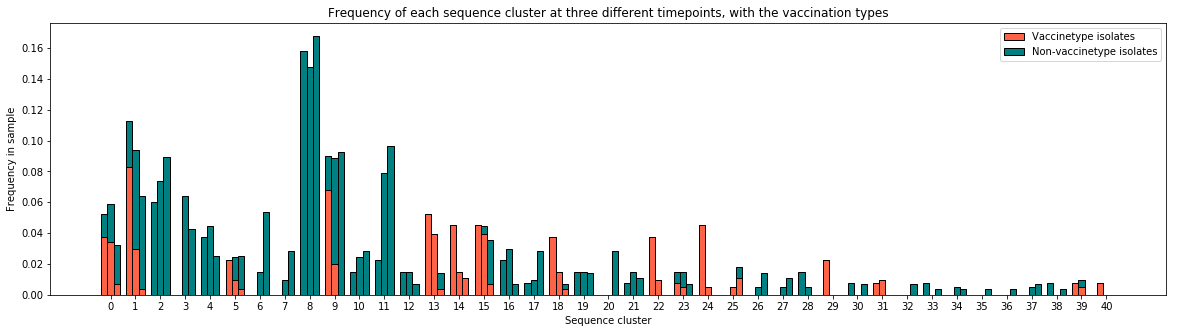

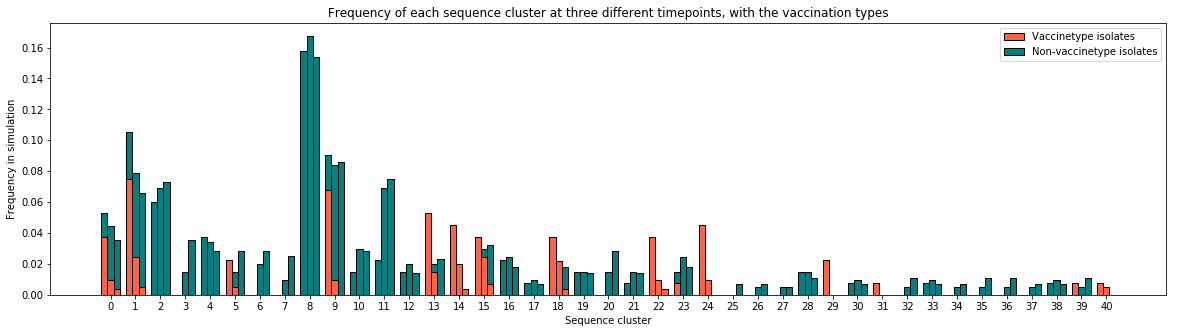

In [32]:
utils.frequency_plot(freq_list, SC, simulation=0)
utils.frequency_plot(median_freqs, SC)

##  Posterior sample

Finally, we use BOLFI to infer approximate posterior distributions for the parameters of the heterogenous multilocus model of NFDS. In practice, this means that we determine an approximate likelihood function based on the probability that the discrepancy between observed and simulated observations is below a certain treshold, and use this to infer the posteriors of the parameters by using importance sampling, in this case with Markov Chain Monte Carlo (MCMC) sampler.

In the following section we are going to take 5000 samples from the resulting BOLFI object using the MCMC sampler.

In [33]:
%time result_BOLFI = he_bolfi.sample(5000, info_freq=5000) #5000

4 chains of 5000 iterations acquired. Effective sample size and Rhat for each parameter:
i 2976.682930891013 1.0015715824727014
j 1621.6369654674968 1.0017925839735462
s 2631.064262106718 1.0011460960624543
v 6154.382214846234 1.0002069159000255
y 9972.864712573228 0.9999786441194285
CPU times: user 3h 3min 10s, sys: 49.8 s, total: 3h 4min
Wall time: 1h 32min 18s


In [34]:
result_BOLFI

Method: BOLFI
Number of samples: 10000
Number of simulations: 2000
Threshold: -2.7
Sample means: i: -5.39, j: -5.44, s: -2.48, v: -2.33, y: 0.425

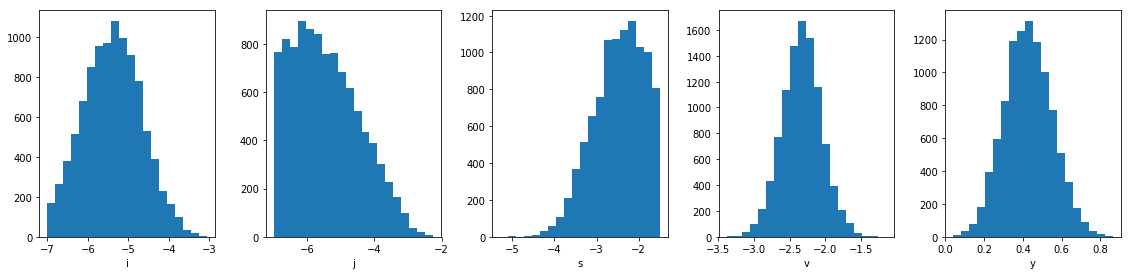

In [35]:
result_BOLFI.plot_marginals();

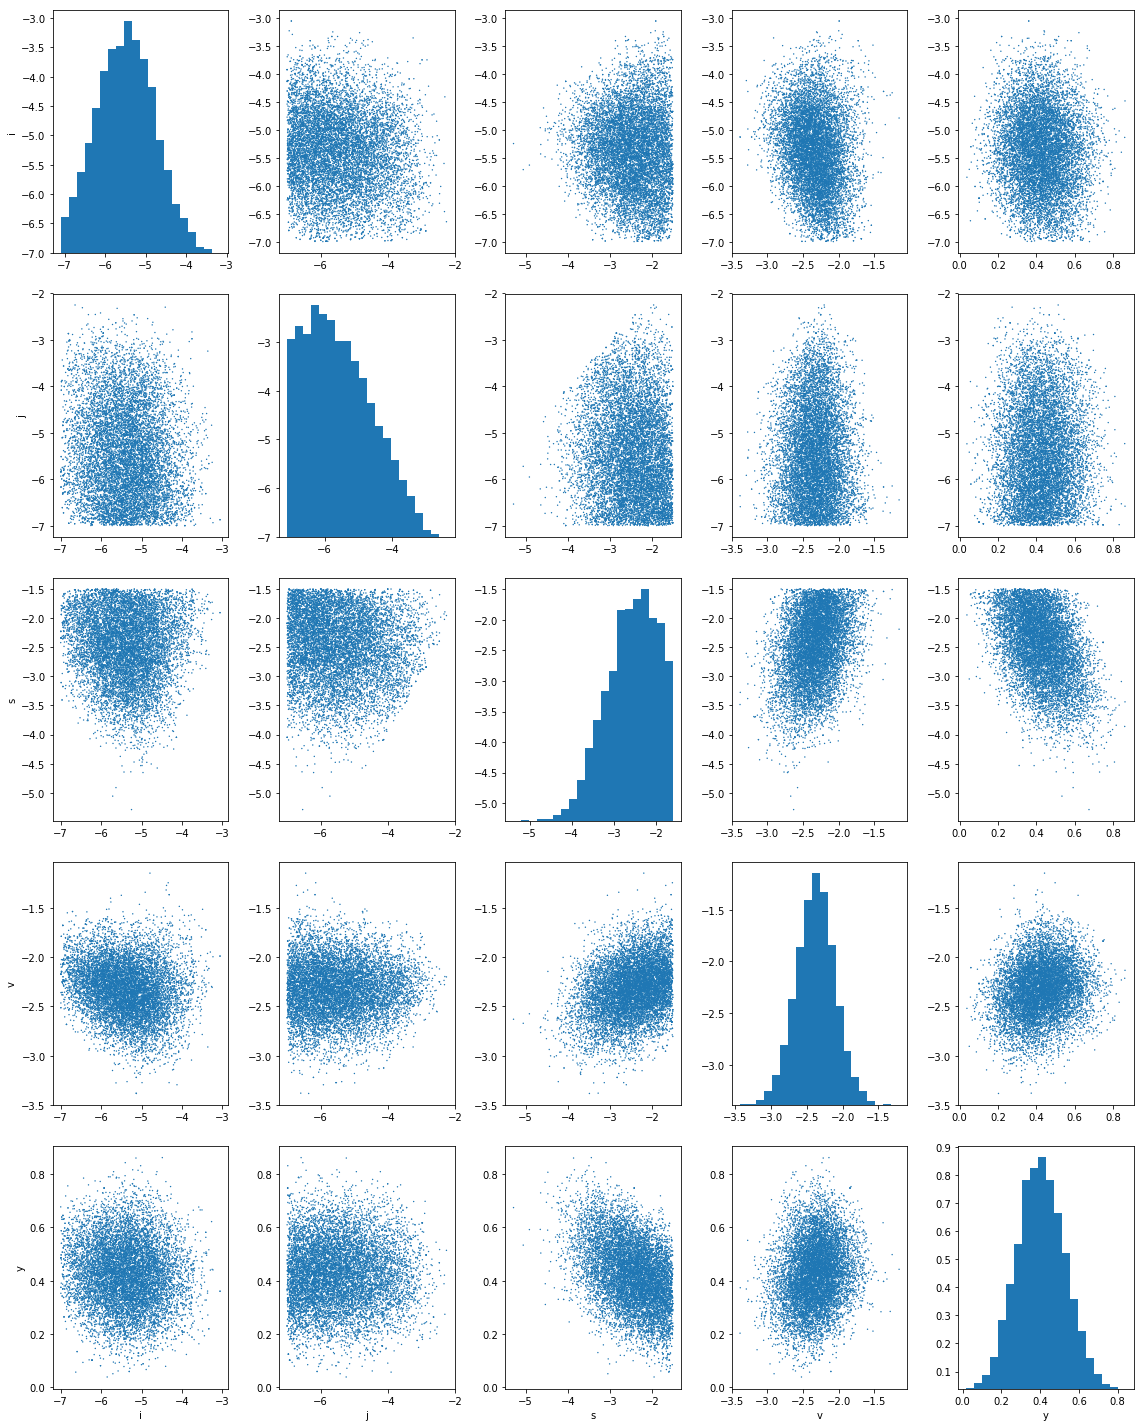

In [36]:
pairs = result_BOLFI.plot_pairs()

## References

- [1] Corander J., Fraser C., Gutmann M.U., et al. (2017). Frequency-dependent selection in vaccine-associated pneumococcal population dynamics. Nature Ecology and Evolution. 1(12):1950–1960.

- [2] Croucher N., Finkelstein J.A., Pelton S.I., et al. (2013). Population genomics of post-vaccine changes in pneumococcal epidemiology. Nature Genetics. 45(6):656-63.

- [3] Gutmann M.U., Corander J. (2016). Bayesian optimization for likelihood-free inference of simulator-based statistical models. Journal of Machine Learning Research 17(125):1-47.

- [4] Lintusaari J., Vuollekoski H., Kangasrääsiö A., et al. (2018). ELFI: Engine for likelihood free inference. Journal of Machine Learning Research. 19(16):1−7.